In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
import numpy as np
import pandas as pd
from collections import Counter
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.preprocessing import FunctionTransformer
import seaborn as sns

# Task1

In [26]:
# ---------- Đường dẫn ----------
MATRIX_PATH = "./brca_matrix_with_label.tsv"          # có cột: File Name, label, ...
META_PATH   = "./tumor_normal_label.csv"     # có cột: File ID, File Name, Case ID, Tissue Type

# ---------- Đọc dữ liệu ----------
df = pd.read_csv(MATRIX_PATH, sep="\t")
meta = pd.read_csv(META_PATH)

# Kiểm tra cột
assert {"File Name","label"}.issubset(df.columns), "Thiếu 'File Name' hoặc 'label' trong matrix."
assert {"File Name","Case ID"}.issubset(meta.columns), "Metadata phải có 'File Name' và 'Case ID'."

# Chỉ giữ các cột gene
meta_cols = ["File Name", "label"]
feature_cols = [c for c in df.columns if c not in meta_cols]

# Ép kiểu số -> float32 (nhẹ RAM)
X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(np.float32)
y_str = df["label"].astype(str).str.strip()
y = y_str.map({"Tumor":1, "Normal":0})
if y.isna().any():
    bad = sorted(y_str[ y.isna() ].unique())
    raise ValueError(f"Nhãn ngoài tập cho phép {{'Tumor','Normal'}}. Gặp: {bad}")

# Ghép Case ID vào từng sample
case_map = meta[["File Name","Case ID"]].drop_duplicates()
data = df[["File Name"]].merge(case_map, on="File Name", how="left")
if data["Case ID"].isna().any():
    miss = data.loc[data["Case ID"].isna(),"File Name"].tolist()
    raise ValueError(f"Không tìm thấy Case ID cho {len(miss)} sample. Ví dụ: {miss[:5]} ...")
groups = data["Case ID"].astype(str).values  # nhóm theo Case ID


# Sau khi kiểm tra nhãn OK
y = y.astype(int).values           # <- ép sang numpy array
groups = groups.astype(str)        # <- nếu cần

# Thông tin nhanh
n_samples, n_genes = X_df.shape
zero_frac = float((X_df.values == 0).mean())
print("===== TỔNG QUAN =====")
print(f"Số mẫu: {n_samples:,} | Số gene: {n_genes:,}")
print(f"Phân bố nhãn: {dict(Counter(y))} (1=Infiltrating duct carcinoma, 0=Lobular carcinoma)")
print(f"Tỉ lệ số 0 toàn ma trận: {zero_frac:.3f}")
print(f"Số Case ID duy nhất (nhóm): {len(np.unique(groups))}")



===== TỔNG QUAN =====
Số mẫu: 1,231 | Số gene: 60,660
Phân bố nhãn: {np.int64(1): 1118, np.int64(0): 113} (1=Infiltrating duct carcinoma, 0=Lobular carcinoma)
Tỉ lệ số 0 toàn ma trận: 0.461
Số Case ID duy nhất (nhóm): 1095


In [27]:
def remove_highly_correlated_features(X, threshold=0.95):
    """
    Một transformer tùy chỉnh để loại bỏ các đặc trưng tương quan cao.
    Lưu ý: Nó nhận vào numpy array (từ bước trước) và trả về numpy array.
    """
    if isinstance(X, sparse.csr_matrix):
        X = X.toarray() # Tính tương quan cần ma trận dày

    # 1. Tạo DataFrame để dễ tính tương quan theo cột
    df = pd.DataFrame(X)
    
    # 2. Tính ma trận tương quan
    corr_matrix = df.corr().abs()

    # 3. Lấy ma trận tam giác trên (loại bỏ đường chéo và lặp lại)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 4. Tìm các cột cần loại bỏ
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # 5. Lấy chỉ số (index) của các cột cần loại bỏ
    # Chúng ta cần index vì đầu vào là numpy
    drop_indices = [df.columns.get_loc(c) for c in to_drop]
    
    # 6. Loại bỏ cột và trả về numpy array
    X_filtered = np.delete(X, drop_indices, axis=1)
    
    # Ghi lại thông tin (tùy chọn)
    print(f"Correlation Filter: In={X.shape[1]} -> Out={X_filtered.shape[1]}")
    
    return X_filtered

# Dùng sparse nếu thưa
USE_SPARSE = zero_frac >= 0.5
X = sparse.csr_matrix(X_df.values) if USE_SPARSE else X_df.values

# ---------- Pipeline tiền xử lý ----------
K_FEATURES = 2000  # điều chỉnh 1000–5000 tuỳ RAM

def log2p_preserve_sparse(A):
    if sparse.issparse(A):
        A = A.copy()
        A.data = np.log2(A.data + 1.0)  # log2(1+x) trên phần tử khác 0; 0 vẫn là 0
        return A
    return np.log2(A + 1.0)


corr_filter = FunctionTransformer(remove_highly_correlated_features, 
                                  kw_args={'threshold': 0.95}, 
                                  validate=False)
preprocess = Pipeline(steps=[
    ("log2p", FunctionTransformer(log2p_preserve_sparse, validate=False)),
    ("var",   VarianceThreshold(threshold=0.0)),
    ("scale", MaxAbsScaler()),
    ("kbest", SelectKBest(score_func=f_classif, k=K_FEATURES)), # Bước 1: Chọn K gene tốt nhất
    ("corr",  corr_filter)                                      # Bước 2: Lọc dư thừa
])


===== PIPELINE VISUALIZATION (Full data, k=100) =====
--- Visualizing for k=100 and correlation threshold=0.95 ---


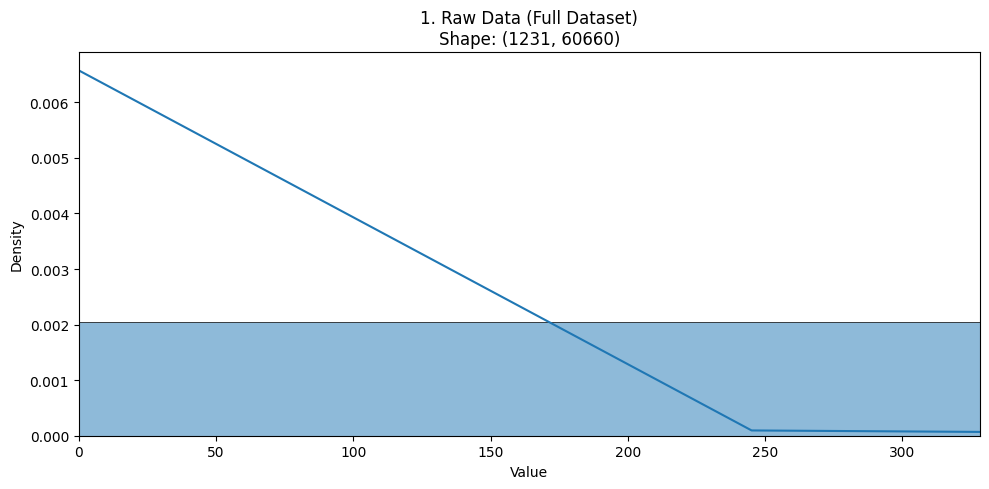

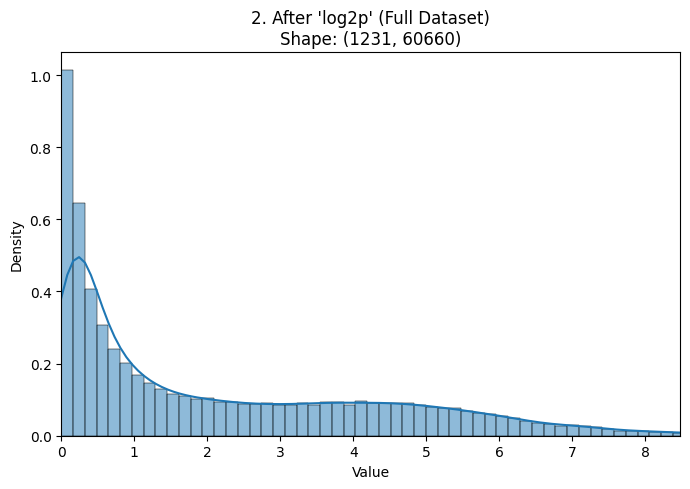


--- Checking 'var' step (on full dataset) ---
Shape before 'var': (1231, 60660)
Shape after 'var': (1231, 58048)
-> Removed: 2612 genes with variance = 0


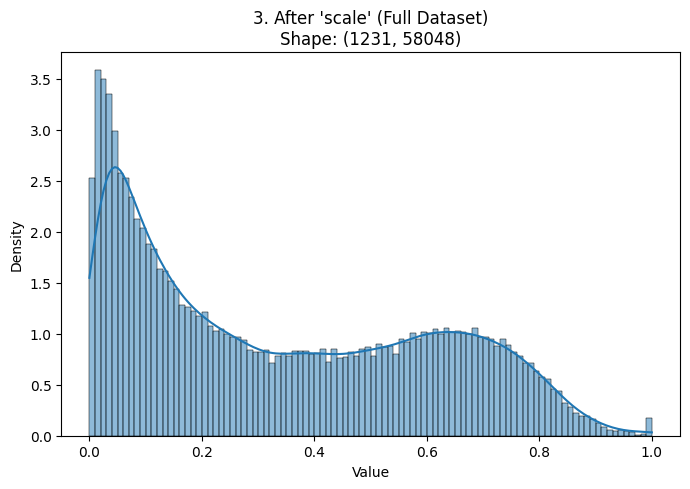

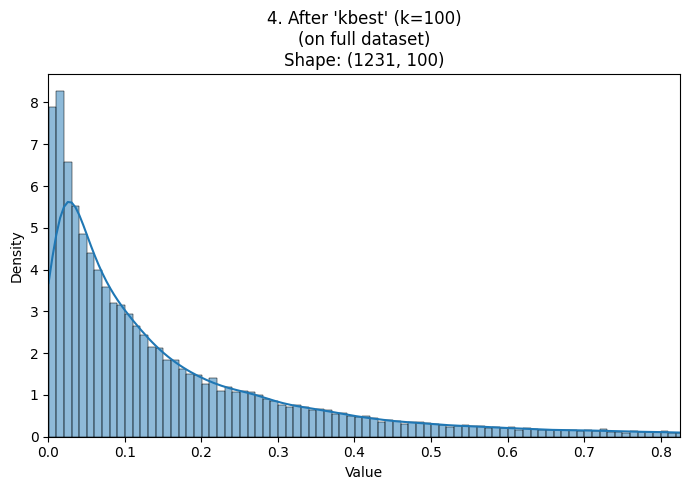


--- Visualizing Correlation Matrix (before 'corr' step) ---
Plotting heatmap for all 100 genes (out of 100 selected)


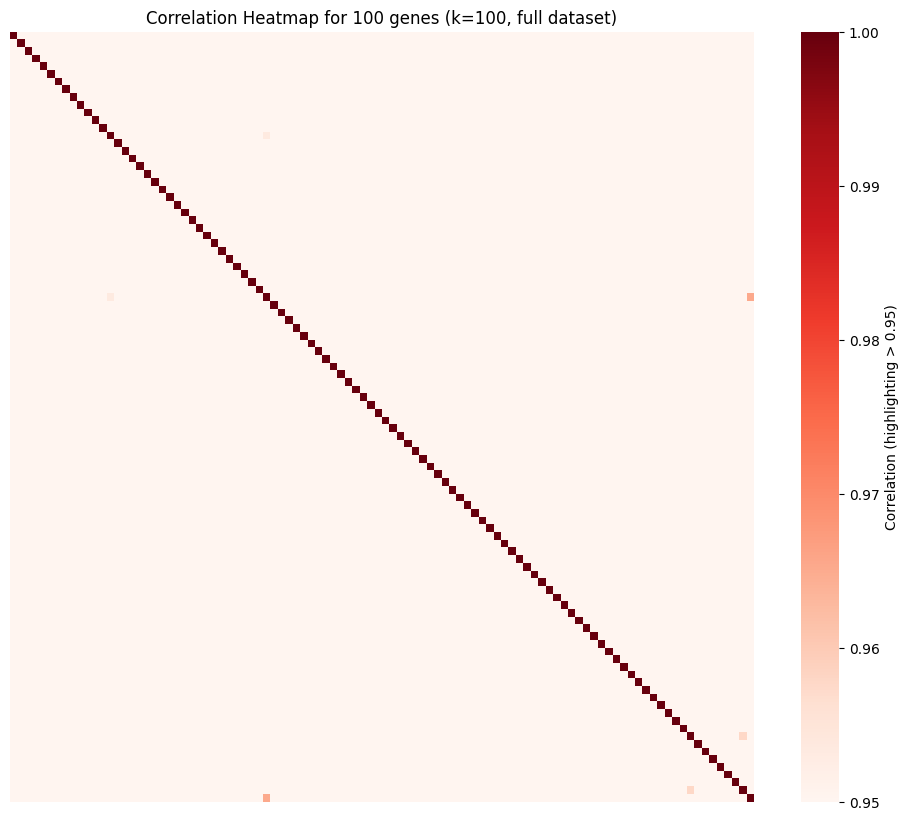


--- Checking 'corr' step (Correlation Filter) (Full data, k=100) ---
Correlation Filter: In=100 -> Out=97
Shape after kbest (k=100): (1231, 100)
Shape after corr (threshold= 0.95): (1231, 97)
-> Removed: 3 correlated genes


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import pandas as pd

print("\n===== PIPELINE VISUALIZATION (Full data, k=100) =====")

# --- Set fixed K for visualization ---
VIZ_K = 100
VIZ_THRESHOLD = 0.95
print(f"--- Visualizing for k={VIZ_K} and correlation threshold={VIZ_THRESHOLD} ---")


# --- Plotting function (updated for English) ---
def sample_data_for_plot(X, n_samples=50000):
    """Sample non-zero data for faster plotting"""
    if sparse.issparse(X):
        non_zero_data = X.data
    else:
        non_zero_data = X[X != 0].flatten()
    
    if non_zero_data.size > n_samples:
        return np.random.choice(non_zero_data, n_samples, replace=False)
    return non_zero_data

def plot_step(ax, data, title):
    """Plot histogram/kde of sampled data"""
    sampled_values = sample_data_for_plot(data)
    if sampled_values.size == 0:
        ax.text(0.5, 0.5, 'No non-zero data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f"{title}\nShape: {data.shape}")
        return
        
    sns.histplot(sampled_values, kde=True, ax=ax, bins=100, stat="density")
    ax.set_title(f"{title}\nShape: {data.shape}")
    ax.set_xlabel("Value") # <-- Changed to English
    if "scale" not in title.lower():
        max_val = np.percentile(sampled_values, 99) 
        if max_val > 0:
            ax.set_xlim(0, max_val)
        else:
            min_val = np.percentile(sampled_values, 1)
            ax.set_xlim(min_val, -min_val if min_val < 0 else 1.0)


# --- Plot 1: Raw Data ---
plt.figure(figsize=(10, 5))
ax1 = plt.gca() # Get current axes
plot_step(ax1, X, "1. Raw Data (Full Dataset)")
plt.tight_layout()
plt.show()

# --- Plot 2: After 'log2p' ---
step_tuple = preprocess.steps[0] # ('log2p', FunctionTransformer)
pipe_log2p = Pipeline(steps=[(step_tuple[0], clone(step_tuple[1]))]) 
data_log2p_full = pipe_log2p.transform(X)

plt.figure(figsize=(7, 5))
ax2 = plt.gca()
plot_step(ax2, data_log2p_full, "2. After 'log2p' (Full Dataset)")
plt.tight_layout()
plt.show()

# --- Info for 'var' step ---
print(f"\n--- Checking 'var' step (on full dataset) ---")
print(f"Shape before 'var': {data_log2p_full.shape}")
try:
    var_step_tuple = preprocess.steps[1] # ('var', VarianceThreshold)
    pipe_var_only = Pipeline(steps=[(var_step_tuple[0], clone(var_step_tuple[1]))])
    pipe_var_only.fit(data_log2p_full, y)
    data_after_var_full = pipe_var_only.transform(data_log2p_full)
    print(f"Shape after 'var': {data_after_var_full.shape}")
    print(f"-> Removed: {data_log2p_full.shape[1] - data_after_var_full.shape[1]} genes with variance = 0")
except Exception as e:
    print(f"Could not run 'var' step independently: {e}")


# --- Plot 3: After 'scale' ---
pipe_scale = Pipeline(steps=[(s[0], clone(s[1])) for s in preprocess.steps[:3]])
pipe_scale.fit(X, y) # Fit on full data
data_scale_full = pipe_scale.transform(X)

plt.figure(figsize=(7, 5))
ax3 = plt.gca()
plot_step(ax3, data_scale_full, "3. After 'scale' (Full Dataset)")
plt.tight_layout()
plt.show()

# --- Plot 4: After 'kbest' ---
pipe_kbest = Pipeline(steps=[(s[0], clone(s[1])) for s in preprocess.steps[:4]])
pipe_kbest.named_steps['kbest'].k = VIZ_K # <-- Use k=100
pipe_kbest.fit(X, y) # <-- Use X, y
data_kbest_full = pipe_kbest.transform(X) # <-- Use X

plt.figure(figsize=(7, 5))
ax4 = plt.gca()
plot_step(ax4, data_kbest_full, f"4. After 'kbest' (k={VIZ_K})\n(on full dataset)")
plt.tight_layout()
plt.show()


# ========== ORDER SWAPPED AS REQUESTED ==========

# --- Part 5 (was 6): Correlation Heatmap ---
print(f"\n--- Visualizing Correlation Matrix (before 'corr' step) ---")

threshold_val = VIZ_THRESHOLD # Use 0.95

if data_kbest_full is not None:
    try:
        N_GENES_TO_PLOT = min(100, VIZ_K) # Will be 100
        print(f"Plotting heatmap for all {N_GENES_TO_PLOT} genes (out of {VIZ_K} selected)")

        if sparse.issparse(data_kbest_full):
            data_kbest_df = pd.DataFrame(data_kbest_full.toarray())
        else:
            data_kbest_df = pd.DataFrame(data_kbest_full)
        
        data_subset = data_kbest_df.iloc[:, :N_GENES_TO_PLOT]
        
        corr_matrix_subset = data_subset.corr().abs()
        
        # This is already a separate figure
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix_subset, 
                    cmap="Reds", 
                    vmin=threshold_val, 
                    vmax=1.0,
                    annot=False, 
                    xticklabels=False,
                    yticklabels=False,
                    cbar_kws={'label': f'Correlation (highlighting > {threshold_val})'}) # <-- Changed to English
        
        plt.title(f"Correlation Heatmap for {N_GENES_TO_PLOT} genes (k={VIZ_K}, full dataset)") # <-- Changed to English
        plt.show()

    except Exception as e:
        print(f"Could not plot heatmap: {e}")
else:
    print("Cannot plot heatmap because data_kbest_full is not available (error in step 4).")


# --- Part 6 (was 5): Info for 'corr' step ---
print(f"\n--- Checking 'corr' step (Correlation Filter) (Full data, k={VIZ_K}) ---")
data_corr_full = None # Initialize
try:
    pipe_full = clone(preprocess)
    pipe_full.set_params(kbest__k=VIZ_K, corr__kw_args={'threshold': VIZ_THRESHOLD}) # <-- Use k=100
    pipe_full.fit(X, y) # <-- Use X, y
    data_corr_full = pipe_full.transform(X) # <-- Use X
    
    print(f"Shape after kbest (k={VIZ_K}): {data_kbest_full.shape}")
    print(f"Shape after corr (threshold= {VIZ_THRESHOLD}): {data_corr_full.shape}")
    print(f"-> Removed: {data_kbest_full.shape[1] - data_corr_full.shape[1]} correlated genes")

except Exception as e:
    print(f"Could not run 'corr' step for visualization: {e}")

# Task2

In [29]:
# ---------- Đường dẫn ----------
MATRIX_PATH = "./brca_matrix_with_label_subtyping.tsv"          # có cột: File Name, label, ...
META_PATH   = "./breast_cancer_annotation.csv"     # có cột: File ID, File Name, Case ID, Tissue Type

# ---------- Đọc dữ liệu ----------
df = pd.read_csv(MATRIX_PATH, sep="\t")
meta = pd.read_csv(META_PATH)

# Kiểm tra cột
assert {"File Name","label"}.issubset(df.columns), "Thiếu 'File Name' hoặc 'label' trong matrix."
assert {"File Name","Case ID"}.issubset(meta.columns), "Metadata phải có 'File Name' và 'Case ID'."

# Chỉ giữ các cột gene
meta_cols = ["File Name", "label"]
feature_cols = [c for c in df.columns if c not in meta_cols]

# Ép kiểu số -> float32 (nhẹ RAM)
X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(np.float32)
y_str = df["label"].astype(str).str.strip()
y = y_str.map({"Infiltrating duct carcinoma":1, "Lobular carcinoma":0})
if y.isna().any():
    bad = sorted(y_str[ y.isna() ].unique())
    raise ValueError(f"Nhãn ngoài tập cho phép {{'Infiltrating duct carcinoma','Lobular carcinoma'}}. Gặp: {bad}")

# Ghép Case ID vào từng sample
case_map = meta[["File Name","Case ID"]].drop_duplicates()
data = df[["File Name"]].merge(case_map, on="File Name", how="left")
if data["Case ID"].isna().any():
    miss = data.loc[data["Case ID"].isna(),"File Name"].tolist()
    raise ValueError(f"Không tìm thấy Case ID cho {len(miss)} sample. Ví dụ: {miss[:5]} ...")
groups = data["Case ID"].astype(str).values  # nhóm theo Case ID


# Sau khi kiểm tra nhãn OK
y = y.astype(int).values           # <- ép sang numpy array
groups = groups.astype(str)        # <- nếu cần

# Thông tin nhanh
n_samples, n_genes = X_df.shape
zero_frac = float((X_df.values == 0).mean())
print("===== TỔNG QUAN =====")
print(f"Số mẫu: {n_samples:,} | Số gene: {n_genes:,}")
print(f"Phân bố nhãn: {dict(Counter(y))} (1=Infiltrating duct carcinoma, 0=Lobular carcinoma)")
print(f"Tỉ lệ số 0 toàn ma trận: {zero_frac:.3f}")
print(f"Số Case ID duy nhất (nhóm): {len(np.unique(groups))}")

===== TỔNG QUAN =====
Số mẫu: 955 | Số gene: 60,660
Phân bố nhãn: {np.int64(1): 767, np.int64(0): 188} (1=Infiltrating duct carcinoma, 0=Lobular carcinoma)
Tỉ lệ số 0 toàn ma trận: 0.462
Số Case ID duy nhất (nhóm): 936


In [30]:
def remove_highly_correlated_features(X, threshold=0.95):
    """
    Một transformer tùy chỉnh để loại bỏ các đặc trưng tương quan cao.
    Lưu ý: Nó nhận vào numpy array (từ bước trước) và trả về numpy array.
    """
    if isinstance(X, sparse.csr_matrix):
        X = X.toarray() # Tính tương quan cần ma trận dày

    # 1. Tạo DataFrame để dễ tính tương quan theo cột
    df = pd.DataFrame(X)
    
    # 2. Tính ma trận tương quan
    corr_matrix = df.corr().abs()

    # 3. Lấy ma trận tam giác trên (loại bỏ đường chéo và lặp lại)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 4. Tìm các cột cần loại bỏ
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # 5. Lấy chỉ số (index) của các cột cần loại bỏ
    # Chúng ta cần index vì đầu vào là numpy
    drop_indices = [df.columns.get_loc(c) for c in to_drop]
    
    # 6. Loại bỏ cột và trả về numpy array
    X_filtered = np.delete(X, drop_indices, axis=1)
    
    # Ghi lại thông tin (tùy chọn)
    print(f"Correlation Filter: In={X.shape[1]} -> Out={X_filtered.shape[1]}")
    
    return X_filtered

# Dùng sparse nếu thưa
USE_SPARSE = zero_frac >= 0.5
X = sparse.csr_matrix(X_df.values) if USE_SPARSE else X_df.values

# ---------- Pipeline tiền xử lý ----------
K_FEATURES = 2000  # điều chỉnh 1000–5000 tuỳ RAM

def log2p_preserve_sparse(A):
    if sparse.issparse(A):
        A = A.copy()
        A.data = np.log2(A.data + 1.0)  # log2(1+x) trên phần tử khác 0; 0 vẫn là 0
        return A
    return np.log2(A + 1.0)


corr_filter = FunctionTransformer(remove_highly_correlated_features, 
                                  kw_args={'threshold': 0.95}, 
                                  validate=False)
preprocess = Pipeline(steps=[
    ("log2p", FunctionTransformer(log2p_preserve_sparse, validate=False)),
    ("var",   VarianceThreshold(threshold=0.0)),
    ("scale", MaxAbsScaler()),
    ("kbest", SelectKBest(score_func=f_classif, k=K_FEATURES)), # Bước 1: Chọn K gene tốt nhất
    ("corr",  corr_filter)                                      # Bước 2: Lọc dư thừa
])


===== PIPELINE VISUALIZATION (Full data, k=100) =====
--- Visualizing for k=100 and correlation threshold=0.95 ---


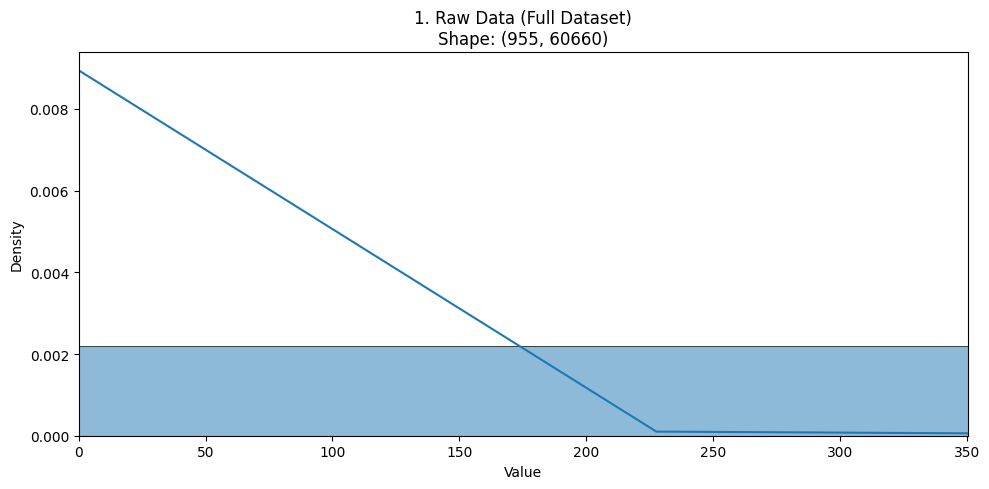

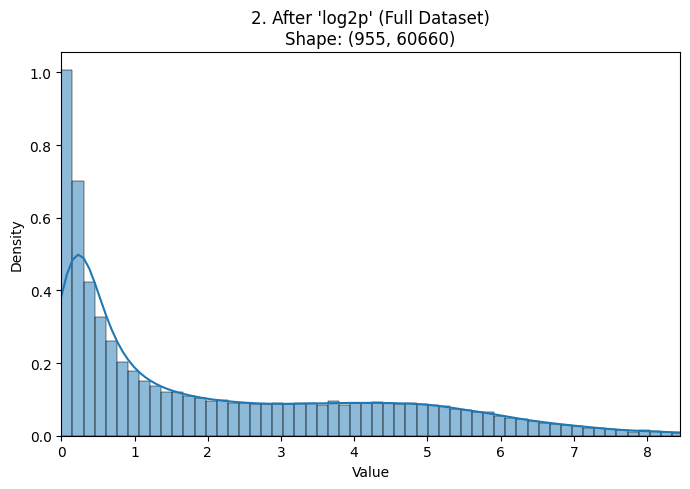


--- Checking 'var' step (on full dataset) ---
Shape before 'var': (955, 60660)
Shape after 'var': (955, 57985)
-> Removed: 2675 genes with variance = 0


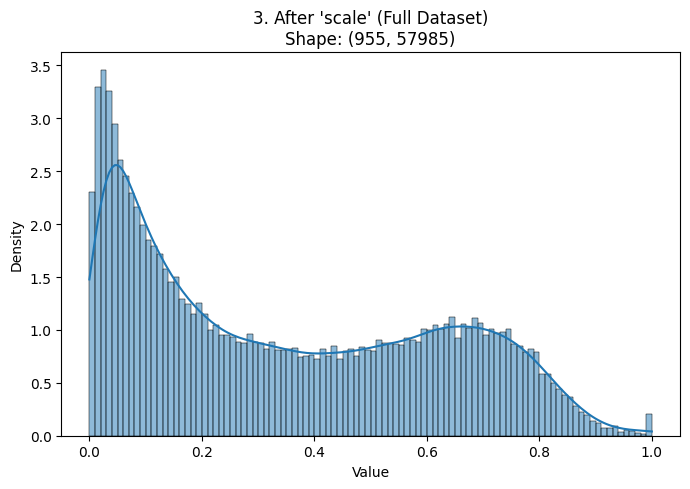

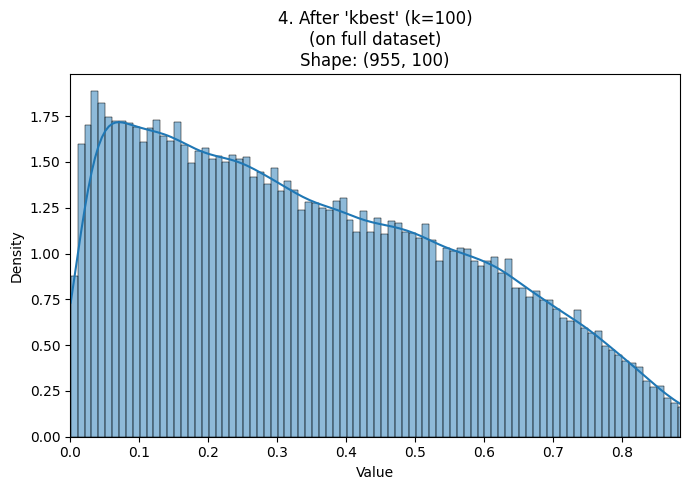


--- Visualizing Correlation Matrix (before 'corr' step) ---
Plotting heatmap for all 100 genes (out of 100 selected)


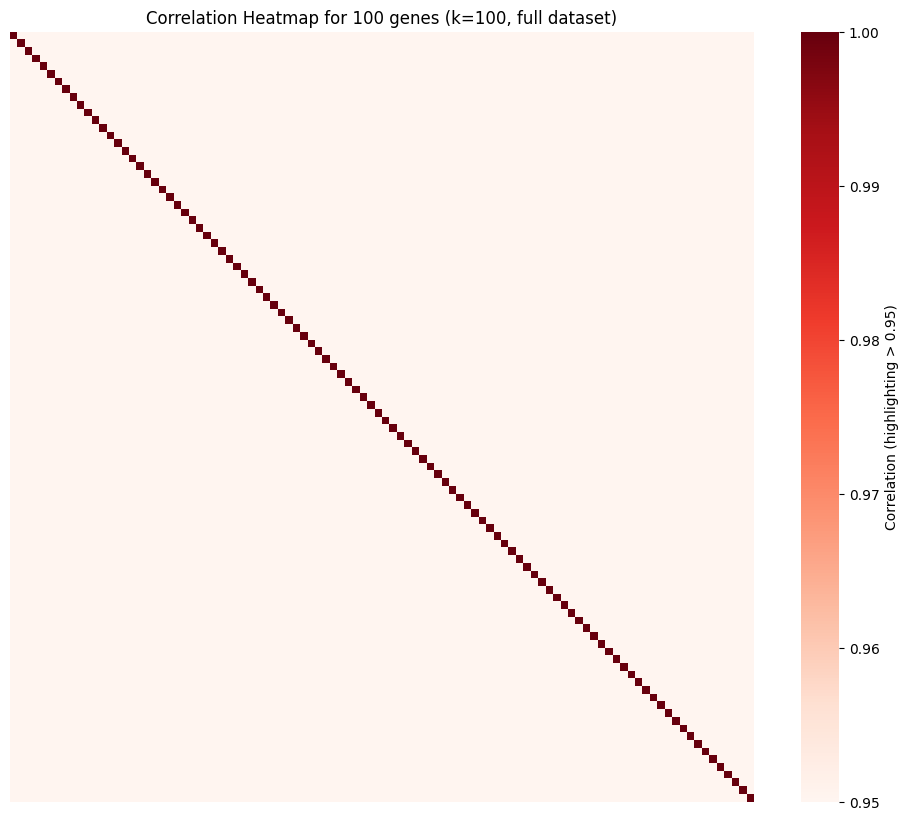


--- Checking 'corr' step (Correlation Filter) (Full data, k=100) ---
Correlation Filter: In=100 -> Out=100
Shape after kbest (k=100): (955, 100)
Shape after corr (threshold= 0.95): (955, 100)
-> Removed: 0 correlated genes


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import pandas as pd

print("\n===== PIPELINE VISUALIZATION (Full data, k=100) =====")

# --- Set fixed K for visualization ---
VIZ_K = 100
VIZ_THRESHOLD = 0.95
print(f"--- Visualizing for k={VIZ_K} and correlation threshold={VIZ_THRESHOLD} ---")


# --- Plotting function (updated for English) ---
def sample_data_for_plot(X, n_samples=50000):
    """Sample non-zero data for faster plotting"""
    if sparse.issparse(X):
        non_zero_data = X.data
    else:
        non_zero_data = X[X != 0].flatten()
    
    if non_zero_data.size > n_samples:
        return np.random.choice(non_zero_data, n_samples, replace=False)
    return non_zero_data

def plot_step(ax, data, title):
    """Plot histogram/kde of sampled data"""
    sampled_values = sample_data_for_plot(data)
    if sampled_values.size == 0:
        ax.text(0.5, 0.5, 'No non-zero data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f"{title}\nShape: {data.shape}")
        return
        
    sns.histplot(sampled_values, kde=True, ax=ax, bins=100, stat="density")
    ax.set_title(f"{title}\nShape: {data.shape}")
    ax.set_xlabel("Value") # <-- Changed to English
    if "scale" not in title.lower():
        max_val = np.percentile(sampled_values, 99) 
        if max_val > 0:
            ax.set_xlim(0, max_val)
        else:
            min_val = np.percentile(sampled_values, 1)
            ax.set_xlim(min_val, -min_val if min_val < 0 else 1.0)


# --- Plot 1: Raw Data ---
plt.figure(figsize=(10, 5))
ax1 = plt.gca() # Get current axes
plot_step(ax1, X, "1. Raw Data (Full Dataset)")
plt.tight_layout()
plt.show()

# --- Plot 2: After 'log2p' ---
step_tuple = preprocess.steps[0] # ('log2p', FunctionTransformer)
pipe_log2p = Pipeline(steps=[(step_tuple[0], clone(step_tuple[1]))]) 
data_log2p_full = pipe_log2p.transform(X)

plt.figure(figsize=(7, 5))
ax2 = plt.gca()
plot_step(ax2, data_log2p_full, "2. After 'log2p' (Full Dataset)")
plt.tight_layout()
plt.show()

# --- Info for 'var' step ---
print(f"\n--- Checking 'var' step (on full dataset) ---")
print(f"Shape before 'var': {data_log2p_full.shape}")
try:
    var_step_tuple = preprocess.steps[1] # ('var', VarianceThreshold)
    pipe_var_only = Pipeline(steps=[(var_step_tuple[0], clone(var_step_tuple[1]))])
    pipe_var_only.fit(data_log2p_full, y)
    data_after_var_full = pipe_var_only.transform(data_log2p_full)
    print(f"Shape after 'var': {data_after_var_full.shape}")
    print(f"-> Removed: {data_log2p_full.shape[1] - data_after_var_full.shape[1]} genes with variance = 0")
except Exception as e:
    print(f"Could not run 'var' step independently: {e}")


# --- Plot 3: After 'scale' ---
pipe_scale = Pipeline(steps=[(s[0], clone(s[1])) for s in preprocess.steps[:3]])
pipe_scale.fit(X, y) # Fit on full data
data_scale_full = pipe_scale.transform(X)

plt.figure(figsize=(7, 5))
ax3 = plt.gca()
plot_step(ax3, data_scale_full, "3. After 'scale' (Full Dataset)")
plt.tight_layout()
plt.show()

# --- Plot 4: After 'kbest' ---
pipe_kbest = Pipeline(steps=[(s[0], clone(s[1])) for s in preprocess.steps[:4]])
pipe_kbest.named_steps['kbest'].k = VIZ_K # <-- Use k=100
pipe_kbest.fit(X, y) # <-- Use X, y
data_kbest_full = pipe_kbest.transform(X) # <-- Use X

plt.figure(figsize=(7, 5))
ax4 = plt.gca()
plot_step(ax4, data_kbest_full, f"4. After 'kbest' (k={VIZ_K})\n(on full dataset)")
plt.tight_layout()
plt.show()


# ========== ORDER SWAPPED AS REQUESTED ==========

# --- Part 5 (was 6): Correlation Heatmap ---
print(f"\n--- Visualizing Correlation Matrix (before 'corr' step) ---")

threshold_val = VIZ_THRESHOLD # Use 0.95

if data_kbest_full is not None:
    try:
        N_GENES_TO_PLOT = min(100, VIZ_K) # Will be 100
        print(f"Plotting heatmap for all {N_GENES_TO_PLOT} genes (out of {VIZ_K} selected)")

        if sparse.issparse(data_kbest_full):
            data_kbest_df = pd.DataFrame(data_kbest_full.toarray())
        else:
            data_kbest_df = pd.DataFrame(data_kbest_full)
        
        data_subset = data_kbest_df.iloc[:, :N_GENES_TO_PLOT]
        
        corr_matrix_subset = data_subset.corr().abs()
        
        # This is already a separate figure
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix_subset, 
                    cmap="Reds", 
                    vmin=threshold_val, 
                    vmax=1.0,
                    annot=False, 
                    xticklabels=False,
                    yticklabels=False,
                    cbar_kws={'label': f'Correlation (highlighting > {threshold_val})'}) # <-- Changed to English
        
        plt.title(f"Correlation Heatmap for {N_GENES_TO_PLOT} genes (k={VIZ_K}, full dataset)") # <-- Changed to English
        plt.show()

    except Exception as e:
        print(f"Could not plot heatmap: {e}")
else:
    print("Cannot plot heatmap because data_kbest_full is not available (error in step 4).")


# --- Part 6 (was 5): Info for 'corr' step ---
print(f"\n--- Checking 'corr' step (Correlation Filter) (Full data, k={VIZ_K}) ---")
data_corr_full = None # Initialize
try:
    pipe_full = clone(preprocess)
    pipe_full.set_params(kbest__k=VIZ_K, corr__kw_args={'threshold': VIZ_THRESHOLD}) # <-- Use k=100
    pipe_full.fit(X, y) # <-- Use X, y
    data_corr_full = pipe_full.transform(X) # <-- Use X
    
    print(f"Shape after kbest (k={VIZ_K}): {data_kbest_full.shape}")
    print(f"Shape after corr (threshold= {VIZ_THRESHOLD}): {data_corr_full.shape}")
    print(f"-> Removed: {data_kbest_full.shape[1] - data_corr_full.shape[1]} correlated genes")

except Exception as e:
    print(f"Could not run 'corr' step for visualization: {e}")

# Task3

## xử lý dữ liệu file clinical

In [1]:
from processClinical import build_os_feature_table
from pathlib import Path
df= build_os_feature_table(Path("/home/uit2023/LuuTru/Thuchd/cs313/CS331/sample/clinical.cart.2025-10-21.json"))
import pandas as pd
df_tumor = pd.read_csv("/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/breast_cancer_annotation.csv")
df_tumor.rename(columns={"Case ID":"submitter_id"}, inplace=True)


In [2]:
df_merge= pd.merge(df,df_tumor, on="submitter_id",how = "inner")

In [3]:
drop_cols= ["positive_ratio","tx_hormone_any","tx_surgery_any","morphology","tx_radiation_any","tx_chemo_any",'disease_type',"primary_diagnosis_x","case_id","gender","ethnicity","country_of_residence_at_enrollment",'tx_surgery_min_days_to_start', 'tx_radiation_min_days_to_start',
       'tx_chemo_min_days_to_start', 'tx_hormone_min_days_to_start',"prior_treatment","prior_malignancy","age_at_index","year_of_diagnosis"]

df_merge.drop(columns=drop_cols, inplace=True)
df_merge=df_merge[df_merge["OS_time_days"]>0]


In [4]:
df_merge.columns

Index(['submitter_id', 'OS_time_days', 'OS_event', 'race', 'ER_status',
       'PR_status', 'HER2_status', 'ajcc_pathologic_stage',
       'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
       'laterality', 'method_of_diagnosis', 'age_at_diagnosis_years',
       'lymph_nodes_positive', 'lymph_nodes_tested', 'menopause_status',
       'File Name', 'primary_diagnosis_y'],
      dtype='object')

## clean data

In [145]:
import numpy as np
import pandas as pd
from pathlib import Path

NA_LIKE = {
    "", "na", "n/a", "nan", "none", "null",
    "not reported", "not available", "unknown", "unspecified",
    "--", "-", ".", "missing"
}

def _normalize_colname(c: str) -> str:
    c = str(c).strip()
    c = c.replace(" ", "_")
    c = c.replace("-", "_")
    return c

def _clean_text_series(s: pd.Series) -> pd.Series:
    # chỉ áp dụng cho object/string
    s2 = s.astype("string").str.strip()
    # chuẩn hoá NA-like
    s2 = s2.replace({x: pd.NA for x in NA_LIKE})
    # optional: lower-case cho đồng nhất
    s2 = s2.str.lower()
    return s2

def clean_clinical(
    df: pd.DataFrame,
    target_time: str = "OS_time_days",
    target_event: str = "OS_event",
    id_col: str = "submitter_id",
    file_col: str = "File Name",
    drop_missing_col_threshold: float = 0.95,   # drop cột missing > 95%
    eps_time: float = 0.5,                      # nếu time==0 thì thay bằng 0.5
):
    df = df.copy()

    # 1) chuẩn hoá tên cột
    df.columns = [_normalize_colname(c) for c in df.columns]
    # sau normalize, File Name thành File_Name (nếu có)
    if file_col in df.columns:
        file_col_norm = file_col
    else:
        file_col_norm = _normalize_colname(file_col)
    file_col = file_col_norm
    id_col = _normalize_colname(id_col)
    target_time = _normalize_colname(target_time)
    target_event = _normalize_colname(target_event)

    # 2) clean text columns
    obj_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()
    for c in obj_cols:
        df[c] = _clean_text_series(df[c])

    # 3) ép kiểu target
    if target_time in df.columns:
        df[target_time] = pd.to_numeric(df[target_time], errors="coerce")

    if target_event in df.columns:
        # chấp nhận {0,1}, {"0","1"}, {"true","false"}, {"yes","no"}
        raw = df[target_event].astype("string").str.strip().str.lower()
        mapped = raw.replace({
            "true": "1", "false": "0",
            "yes": "1", "no": "0",
            "alive": "0", "dead": "1"
        })
        df[target_event] = pd.to_numeric(mapped, errors="coerce")

    # 4) lọc dòng target lỗi (survival)
    # - time phải có và >=0
    # - event phải là 0/1 (nếu thiếu coi là 0 thì tuỳ bạn; mình để thiếu -> NaN rồi drop nếu không hợp lệ)
    before_rows = len(df)
    if target_time in df.columns:
        df = df[df[target_time].notna()].copy()
        df = df[df[target_time] >= 0].copy()
        df.loc[df[target_time] == 0, target_time] = eps_time

    if target_event in df.columns:
        df = df[df[target_event].isin([0, 1])].copy()
        df[target_event] = df[target_event].astype(int)

    # 5) dedup theo patient/case id
    # chọn dòng ít missing nhất trong group (ưu tiên tốt cho clinical)
    if id_col in df.columns:
        # tính missing per row
        row_missing = df.isna().mean(axis=1)
        df["_row_missing_rate"] = row_missing

        sort_cols = [id_col, "_row_missing_rate"]
        ascending = [True, True]
        if file_col in df.columns:
            sort_cols.append(file_col)
            ascending.append(True)

        df = df.sort_values(sort_cols, ascending=ascending)
        df = df.groupby(id_col, as_index=False).first()
        df = df.drop(columns=["_row_missing_rate"], errors="ignore")

    after_rows = len(df)

    # 6) drop cột missing quá nhiều (tuỳ chọn)
    miss = df.isna().mean()
    drop_cols = miss[miss > drop_missing_col_threshold].index.tolist()
    # không drop id/target
    protect = {id_col, target_time, target_event, file_col}
    drop_cols = [c for c in drop_cols if c not in protect]
    df = df.drop(columns=drop_cols)

    report = {
        "rows_before": int(before_rows),
        "rows_after": int(after_rows),
        "dropped_columns_missing_gt_threshold": drop_cols,
        "missing_rate_top10": miss.sort_values(ascending=False).head(10).to_dict(),
        "event_rate": float(df[target_event].mean()) if target_event in df.columns and len(df) else None
    }
    return df, report

# ===== Example usage =====
#DATA_PATH = Path("/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/clinical.csv")
df_raw = df_merge

df_clean, report = clean_clinical(df_raw)

print("Cleaned shape:", df_clean.shape)
print("Report:", report)

# out_csv = Path("/mnt/data/clinical_clean.csv")
# df_clean.to_csv(out_csv, index=False)
# print("Saved:", out_csv)


Cleaned shape: (918, 19)
Report: {'rows_before': 937, 'rows_after': 918, 'dropped_columns_missing_gt_threshold': [], 'missing_rate_top10': {'lymph_nodes_positive': 0.13616557734204793, 'lymph_nodes_tested': 0.10348583877995643, 'HER2_status': 0.09803921568627451, 'method_of_diagnosis': 0.08387799564270153, 'race': 0.07952069716775599, 'menopause_status': 0.06971677559912855, 'PR_status': 0.04357298474945534, 'ER_status': 0.042483660130718956, 'age_at_diagnosis_years': 0.013071895424836602, 'ajcc_pathologic_stage': 0.00980392156862745}, 'event_rate': 0.12962962962962962}


In [146]:
print("Before cleaning:")
print(df_clean.isnull().sum())

Before cleaning:
submitter_id                0
OS_time_days                0
OS_event                    0
race                       73
ER_status                  39
PR_status                  40
HER2_status                90
ajcc_pathologic_stage       9
ajcc_pathologic_t           0
ajcc_pathologic_n           0
ajcc_pathologic_m           0
laterality                  1
method_of_diagnosis        77
age_at_diagnosis_years     12
lymph_nodes_positive      125
lymph_nodes_tested         95
menopause_status           64
File_Name                   0
primary_diagnosis_y         0
dtype: int64


In [147]:
# =========================
# value_counts() cho cột category
# =========================
import pandas as pd

TOP_K = 20  # đổi số lượng bạn muốn xem

cat_cols = df_clean.select_dtypes(include=["object", "string", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

tmp = df_clean.copy()
for c in cat_cols:
    tmp[c] = tmp[c].astype("string").str.strip()

for c in cat_cols:
    print("\n" + "="*100)
    print(f"COLUMN: {c}")
    vc = tmp[c].value_counts(dropna=False)
    print(f"n_unique(non-null)={tmp[c].nunique(dropna=True)} | missing={tmp[c].isna().sum()} | total={len(tmp)}")
    print(vc.head(TOP_K))


Categorical columns: ['submitter_id', 'race', 'ER_status', 'PR_status', 'HER2_status', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'laterality', 'method_of_diagnosis', 'menopause_status', 'File_Name', 'primary_diagnosis_y']

COLUMN: submitter_id
n_unique(non-null)=918 | missing=0 | total=918
submitter_id
tcga-3c-aaau    1
tcga-3c-aali    1
tcga-3c-aalj    1
tcga-3c-aalk    1
tcga-4h-aaak    1
tcga-5l-aat1    1
tcga-a1-a0sd    1
tcga-a1-a0sf    1
tcga-a1-a0sh    1
tcga-a1-a0si    1
tcga-a1-a0sj    1
tcga-a1-a0sm    1
tcga-a1-a0sn    1
tcga-a1-a0so    1
tcga-a1-a0sq    1
tcga-a2-a04n    1
tcga-a2-a04p    1
tcga-a2-a04q    1
tcga-a2-a04r    1
tcga-a2-a04t    1
Name: count, dtype: Int64

COLUMN: race
n_unique(non-null)=4 | missing=73 | total=918
race
white                               637
black or african american           155
<NA>                                 73
asian                                52
american indian or alaska native      1

In [148]:
import pandas as pd
import numpy as np
import re

def clean_categories(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    def _nanize(s: pd.Series) -> pd.Series:
        s = s.astype("string").str.strip().str.lower()
        s = s.replace({"unknown": pd.NA, "not reported": pd.NA, "not available": pd.NA})
        return s

    # ========== race ==========
    if "race" in df.columns:
        s = _nanize(df["race"]).replace({"american indian or alaska native": "other"})
        df["race"] = s.fillna("unknown")

    # ========== ER/PR ==========
    for c in ["ER_status", "PR_status"]:
        if c in df.columns:
            df[c] = _nanize(df[c]).fillna("unknown")

    # ========== HER2 ==========
    if "HER2_status" in df.columns:
        s = _nanize(df["HER2_status"]).replace({
            "test value reported": "unknown",
            "copy number reported": "unknown",
        })
        df["HER2_status"] = s.fillna("unknown")

    # ========== AJCC stage -> stage_group + stage_sub ==========
    if "ajcc_pathologic_stage" in df.columns:
        s = _nanize(df["ajcc_pathologic_stage"]).replace({"stage x": pd.NA})

        def stage_group(x):
            if pd.isna(x): return "unknown"
            m = re.match(r"stage\s+([ivx]+)", x)
            if not m: return "unknown"
            g = m.group(1)
            return "unknown" if g == "x" else g.upper()

        def stage_sub(x):
            if pd.isna(x): return "unknown"
            m = re.match(r"stage\s+([ivx]+)([abc])$", x)
            if m and m.group(2) in ["a", "b", "c"]:
                return m.group(2)
            m2 = re.match(r"stage\s+([ivx]+)$", x)
            return "none" if m2 else "unknown"

        df["stage_group"] = s.map(stage_group)
        df["stage_sub"] = s.map(stage_sub)
        df = df.drop(columns=["ajcc_pathologic_stage"], errors="ignore")

    # ========== AJCC T (giữ t_suffix) ==========
    if "ajcc_pathologic_t" in df.columns:
        s0 = _nanize(df["ajcc_pathologic_t"]).replace({"tx": pd.NA})

        # suffix chỉ lấy khi dạng t<digit><letter> (t1c)
        t_suffix = s0.str.extract(r"^t\d([a-z])$")[0]
        t_suffix = t_suffix.where(t_suffix.isin(["a", "b", "c", "d"]), pd.NA)

        # base lấy t<digit>
        t_base = s0.str.replace(r"^(t[0-9]).*$", r"\1", regex=True)

        df["ajcc_pathologic_t"] = t_base.fillna("unknown")
        df["t_suffix"] = t_suffix.fillna("none")
        df.loc[df["ajcc_pathologic_t"] == "unknown", "t_suffix"] = "unknown"

    # ========== AJCC N (SỬA: giữ suffix + flags chi tiết) ==========
    if "ajcc_pathologic_n" in df.columns:
        s0 = _nanize(df["ajcc_pathologic_n"]).replace({"nx": pd.NA})

        # flags chi tiết
        n_is_mi = s0.str.fullmatch(r"n1mi", na=False).astype(int)
        n0_i_plus = s0.str.contains(r"^n0\s*\(i\+\)$", regex=True, na=False).astype(int)
        n0_mol_plus = s0.str.contains(r"^n0\s*\(mol\+\)$", regex=True, na=False).astype(int)

        # suffix a/b/c nếu dạng n<digit><letter> (n1a, n3b...)
        n_suffix = s0.str.extract(r"^n\d([abc])$")[0]
        n_suffix = n_suffix.where(n_suffix.isin(["a", "b", "c"]), pd.NA)

        # n_base: rút gọn
        s = s0.str.replace(r"^n0.*$", "n0", regex=True)              # n0(...) -> n0
        s = s.str.replace(r"^(n[0-9]).*$", r"\1", regex=True)        # n1a/n1mi -> n1, n2a->n2, n3b->n3
        df["n_base"] = s.fillna("unknown")

        # ghi các cột chi tiết
        df["n_suffix"] = n_suffix.fillna("none")
        df["n_is_mi"] = n_is_mi
        df["n0_i_plus"] = n0_i_plus
        df["n0_mol_plus"] = n0_mol_plus

        # micrometastasis tổng hợp (nâng cao)
        df["n_micrometastasis"] = ((df["n_is_mi"] == 1) | (df["n0_i_plus"] == 1) | (df["n0_mol_plus"] == 1)).astype(int)

        # nếu unknown -> set flags 0 và suffix unknown
        unk = df["n_base"] == "unknown"
        df.loc[unk, ["n_is_mi", "n0_i_plus", "n0_mol_plus", "n_micrometastasis"]] = 0
        df.loc[unk, "n_suffix"] = "unknown"

        # nếu bạn muốn thay thế cột gốc bằng n_base:
        df = df.drop(columns=["ajcc_pathologic_n"], errors="ignore")
        df = df.rename(columns={"n_base": "ajcc_pathologic_n"})

    # ========== AJCC M ==========
    if "ajcc_pathologic_m" in df.columns:
        s = _nanize(df["ajcc_pathologic_m"]).replace({"mx": pd.NA})
        s = s.replace({"cm0 (i+)": "m0"})
        s = s.where(s.isin(["m0", "m1"]), pd.NA)
        df["ajcc_pathologic_m"] = s.fillna("unknown")

    # ========== laterality ==========
    if "laterality" in df.columns:
        df["laterality"] = _nanize(df["laterality"]).fillna("unknown")
        df.loc[df["laterality"] == "unknown", "laterality"] = "left"

    # ========== method_of_diagnosis ==========
    if "method_of_diagnosis" in df.columns:
        s = _nanize(df["method_of_diagnosis"])
        biopsy_set = {
            "core biopsy", "fine needle aspiration", "excisional biopsy",
            "incisional biopsy", "ultrasound guided biopsy", "biopsy"
        }
        s = s.apply(lambda x: "biopsy" if x in biopsy_set else x)
        s = s.replace({"surgical resection": "surgery"})
        df["method_of_diagnosis"] = s.fillna("unknown")

    # ========== menopause_status ==========
    if "menopause_status" in df.columns:
        df["menopause_status"] = _nanize(df["menopause_status"]).fillna("unknown")

    # ========== Final unify rules ==========
    # equivocal rất hiếm -> unknown
    for c in ["ER_status", "PR_status"]:
        if c in df.columns:
            df[c] = df[c].astype("string").str.strip().str.lower().replace({"equivocal": "unknown"}).fillna("unknown")

    # race other (1 mẫu) -> unknown
    if "race" in df.columns:
        df["race"] = df["race"].astype("string").str.strip().str.lower().replace({"other": "unknown"}).fillna("unknown")

    return df

def clean_numeric(df: pd.DataFrame, add_missing_flags: bool = True) -> pd.DataFrame:
    df = df.copy()

    # drop positive_ratio
    df = df.drop(columns=["positive_ratio"], errors="ignore")

    cols = ["age_at_diagnosis_years", "lymph_nodes_positive", "lymph_nodes_tested"]
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # age sanity (dữ liệu bạn đã hợp lý, vẫn giữ guard)
    if "age_at_diagnosis_years" in df.columns:
        df.loc[(df["age_at_diagnosis_years"] < 0) | (df["age_at_diagnosis_years"] > 120),
               "age_at_diagnosis_years"] = np.nan

    # lymph nodes sanity
    if "lymph_nodes_positive" in df.columns:
        df.loc[df["lymph_nodes_positive"] < 0, "lymph_nodes_positive"] = np.nan

    if "lymph_nodes_tested" in df.columns:
        df.loc[df["lymph_nodes_tested"] < 0, "lymph_nodes_tested"] = np.nan

    # enforce positive <= tested
    if "lymph_nodes_positive" in df.columns and "lymph_nodes_tested" in df.columns:
        bad = (
            df["lymph_nodes_positive"].notna() &
            df["lymph_nodes_tested"].notna() &
            (df["lymph_nodes_positive"] > df["lymph_nodes_tested"])
        )
        # sửa tested = positive để hợp lệ
        df.loc[bad, "lymph_nodes_tested"] = df.loc[bad, "lymph_nodes_positive"]

    # missing flags (rất hữu ích khi missing nhiều như bạn)
    if add_missing_flags:
        for c in cols:
            if c in df.columns:
                df[c + "_was_missing"] = df[c].isna().astype(int)

    # impute median
    for c in cols:
        if c in df.columns:
            med = df[c].median(skipna=True)
            df[c] = df[c].fillna(med)

    return df

df_clean= clean_categories(df_clean)
df_clean= clean_numeric(df_clean)

In [149]:
print("\nAfter category cleaning:")
cat_cols = df_clean.select_dtypes(include=["object", "string", "category"]).columns.tolist()
#cat_cols = ["t_suffix","ajcc_pathologic_t"]

for c in cat_cols:
    print("\n" + "="*100)
    print(f"COLUMN: {c}")
    vc = df_clean[c].value_counts(dropna=False)
    print(f"n_unique(non-null)={df_clean[c].nunique(dropna=True)} | missing={df_clean[c].isna().sum()} | total={len(df_clean)}")
    print(vc.head(TOP_K))


After category cleaning:

COLUMN: submitter_id
n_unique(non-null)=918 | missing=0 | total=918
submitter_id
tcga-3c-aaau    1
tcga-3c-aali    1
tcga-3c-aalj    1
tcga-3c-aalk    1
tcga-4h-aaak    1
tcga-5l-aat1    1
tcga-a1-a0sd    1
tcga-a1-a0sf    1
tcga-a1-a0sh    1
tcga-a1-a0si    1
tcga-a1-a0sj    1
tcga-a1-a0sm    1
tcga-a1-a0sn    1
tcga-a1-a0so    1
tcga-a1-a0sq    1
tcga-a2-a04n    1
tcga-a2-a04p    1
tcga-a2-a04q    1
tcga-a2-a04r    1
tcga-a2-a04t    1
Name: count, dtype: Int64

COLUMN: race
n_unique(non-null)=4 | missing=0 | total=918
race
white                        637
black or african american    155
unknown                       74
asian                         52
Name: count, dtype: Int64

COLUMN: ER_status
n_unique(non-null)=3 | missing=0 | total=918
ER_status
positive    669
negative    208
unknown      41
Name: count, dtype: Int64

COLUMN: PR_status
n_unique(non-null)=3 | missing=0 | total=918
PR_status
positive    585
negative    289
unknown      44
Name: count, d

In [150]:
print("After cleaning:")
print(df_clean.isnull().sum())

After cleaning:
submitter_id                          0
OS_time_days                          0
OS_event                              0
race                                  0
ER_status                             0
PR_status                             0
HER2_status                           0
ajcc_pathologic_t                     0
ajcc_pathologic_m                     0
laterality                            0
method_of_diagnosis                   0
age_at_diagnosis_years                0
lymph_nodes_positive                  0
lymph_nodes_tested                    0
menopause_status                      0
File_Name                             0
primary_diagnosis_y                   0
stage_group                           0
stage_sub                             0
t_suffix                              0
ajcc_pathologic_n                     0
n_suffix                              0
n_is_mi                               0
n0_i_plus                             0
n0_mol_plus             

In [151]:
df_clean

,submitter_id,OS_time_days,OS_event,race,ER_status,PR_status,HER2_status,ajcc_pathologic_t,ajcc_pathologic_m,laterality,...,t_suffix,ajcc_pathologic_n,n_suffix,n_is_mi,n0_i_plus,n0_mol_plus,n_micrometastasis,age_at_diagnosis_years_was_missing,lymph_nodes_positive_was_missing,lymph_nodes_tested_was_missing
0,tcga-3c-aaau,4047.0,0,white,positive,positive,negative,unknown,unknown,left,...,unknown,unknown,unknown,0,0,0,0,0,0,0
1,tcga-3c-aali,4005.0,0,black or african american,positive,positive,positive,t2,m0,right,...,none,n1,a,0,0,0,0,0,0,0
2,tcga-3c-aalj,1474.0,0,black or african american,positive,positive,equivocal,t2,m0,right,...,none,n1,a,0,0,0,0,0,0,0
3,tcga-3c-aalk,1448.0,0,black or african american,positive,positive,positive,t1,m0,right,...,c,n0,none,0,1,0,1,0,0,0
4,tcga-4h-aaak,348.0,0,white,positive,positive,equivocal,t2,m0,left,...,none,n2,a,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,tcga-w8-a86g,347.0,0,white,positive,positive,negative,t2,unknown,left,...,a,n0,none,0,0,0,0,0,0,0
914,tcga-wt-ab44,883.0,0,white,positive,positive,negative,t1,unknown,left,...,c,n0,none,0,0,0,0,1,0,0
915,tcga-xx-a899,467.0,0,white,positive,positive,negative,t1,unknown,right,...,c,n2,a,0,0,0,0,0,0,0
916,tcga-xx-a89a,488.0,0,white,positive,positive,negative,t3,unknown,left,...,none,n0,none,0,0,0,0,0,0,0


In [152]:
df_clean.to_csv("clinical_features_cleaned.csv", index=False)

In [153]:
df_clean["OS_time_days"].value_counts()

OS_time_days
10.0      15
365.0      6
385.0      5
375.0      5
30.0       5
          ..
1864.0     1
2629.0     1
4894.0     1
1548.0     1
2856.0     1
Name: count, Length: 723, dtype: int64

# show ảnh data preprocessing

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest

from sksurv.metrics import concordance_index_censored


# ============================================================
# Helpers: IO
# ============================================================
def unify_file_col(df: pd.DataFrame) -> pd.DataFrame:
    """Đảm bảo clinical có cột 'File Name' để merge."""
    df = df.copy()
    if "File Name" not in df.columns and "File_Name" in df.columns:
        df = df.rename(columns={"File_Name": "File Name"})
    return df


def load_and_join(
    matrix_path: str,
    clinical_path: str,
    file_col: str = "File Name",
    time_col: str = "OS_time_days",
    event_col: str = "OS_event",
    sep_gene: str = "\t",
    drop_gene_label_col: str = "label",
) -> tuple[pd.DataFrame, list[str]]:
    """
    Load gene matrix + clinical, merge theo File Name, clean outcome cơ bản.
    Trả về:
      - df: dataframe đã join
      - gene_cols: list gene columns
    """
    # gene
    df_gene = pd.read_csv(matrix_path, sep=sep_gene)
    if drop_gene_label_col in df_gene.columns:
        df_gene = df_gene.drop(columns=[drop_gene_label_col])

    if file_col not in df_gene.columns:
        raise ValueError(f"Không thấy cột '{file_col}' trong gene matrix.")

    df_gene[file_col] = df_gene[file_col].astype(str).str.strip()
    gene_cols = [c for c in df_gene.columns if c != file_col]
    df_gene[gene_cols] = df_gene[gene_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

    min_val = df_gene[gene_cols].to_numpy().min()
    if min_val < 0:
        raise ValueError(f"Gene matrix có giá trị âm (min={min_val}). Log2(1+x) không hợp lệ.")

    # clinical
    df_clin = unify_file_col(pd.read_csv(clinical_path))
    for c in [file_col, time_col, event_col]:
        if c not in df_clin.columns:
            raise ValueError(f"Clinical thiếu cột bắt buộc: {c}")

    df_clin[file_col] = df_clin[file_col].astype(str).str.strip()
    if df_clin[file_col].duplicated().any():
        df_clin = df_clin.drop_duplicates(subset=[file_col], keep="first")

    # join
    df = df_gene.merge(df_clin, on=file_col, how="inner", validate="one_to_one")

    # outcome clean
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[event_col] = pd.to_numeric(df[event_col], errors="coerce")
    df = df.dropna(subset=[time_col, event_col])
    df = df[df[time_col] > 0]
    df[event_col] = df[event_col].astype(int)

    return df, gene_cols


# ============================================================
# Helpers: survival score for SelectKBest
# ============================================================
def _extract_time_event(y):
    # y phải là structured array của sksurv: Surv.from_arrays(...)
    if hasattr(y, "dtype") and y.dtype.names is not None:
        if "time" in y.dtype.names and "event" in y.dtype.names:
            return y["time"].astype(float), y["event"].astype(bool)
    raise ValueError("y phải là Surv.from_arrays(event=..., time=...).")


def cindex_survival_score(X, y):
    """
    Score_func cho SelectKBest (survival):
      score_j = max(ci(x_j), ci(-x_j)) - 0.5   (>=0)
    """
    time, event = _extract_time_event(y)

    if sparse.issparse(X):
        X = X.tocsc()  # lấy cột nhanh

    n_features = X.shape[1]
    scores = np.zeros(n_features, dtype=float)
    pvals = np.full(n_features, np.nan, dtype=float)

    for j in range(n_features):
        if sparse.issparse(X):
            xj = X.getcol(j).toarray().ravel()
        else:
            xj = np.asarray(X[:, j]).ravel()

        xj = np.nan_to_num(xj, nan=0.0, posinf=0.0, neginf=0.0)
        if np.std(xj) == 0:
            scores[j] = 0.0
            continue

        ci1 = concordance_index_censored(event, time, xj)[0]
        ci2 = concordance_index_censored(event, time, -xj)[0]
        scores[j] = max(0.0, max(ci1, ci2) - 0.5)

    return scores, pvals


# ============================================================
# Transformers
# ============================================================
def _log2p(A):
    if sparse.issparse(A):
        B = A.copy()
        B.data = np.log2(B.data + 1.0)
        return B
    return np.log2(A + 1.0)


class TopKVariance(BaseEstimator, TransformerMixin):
    """Giữ k feature có variance lớn nhất (unsupervised)."""
    def __init__(self, k=10000):
        self.k = int(k)
        self.idx_ = None

    def fit(self, X, y=None):
        if sparse.issparse(X):
            Xc = X.tocsc()
            mean = np.array(Xc.mean(axis=0)).ravel()
            mean2 = np.array(Xc.power(2).mean(axis=0)).ravel()
            var = mean2 - mean**2
        else:
            var = np.var(np.asarray(X), axis=0)

        k = min(self.k, var.shape[0])
        self.idx_ = np.argsort(var)[::-1][:k]
        return self

    def transform(self, X):
        if self.idx_ is None:
            raise RuntimeError("TopKVariance chưa fit.")
        return X[:, self.idx_]


class AddOrdinalStageTNM(BaseEstimator, TransformerMixin):
    """
    Thêm các cột ordinal: stage_num/t_num/n_num/m_num + *_unk
    Input/Output: pandas DataFrame
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        def _make(col, mapping, num_col, unk_col):
            if col not in df.columns:
                return
            s = df[col].astype("string").str.strip().str.lower()
            num = s.map(mapping)
            df[num_col] = num.fillna(-1).astype(int)
            df[unk_col] = num.isna().astype(int)

        _make("stage_group", {"i": 1, "ii": 2, "iii": 3, "iv": 4}, "stage_num", "stage_unk")
        _make("ajcc_pathologic_t", {"t1": 1, "t2": 2, "t3": 3, "t4": 4}, "t_num", "t_unk")
        _make("ajcc_pathologic_n", {"n0": 0, "n1": 1, "n2": 2, "n3": 3}, "n_num", "n_unk")
        _make("ajcc_pathologic_m", {"m0": 0, "m1": 1}, "m_num", "m_unk")

        return df


class DenseFloat64(BaseEstimator, TransformerMixin):
    """CoxnetSurvivalAnalysis không nhận sparse => convert sang dense float64."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        return np.asarray(X, dtype=np.float64, order="C")


# ============================================================
# Build preprocess pipelines
# ============================================================
def make_gene_preprocess(var_threshold=0.0, k0_topvar=10000, k_genes=500) -> Pipeline:
    """
    Gene: log2p -> var -> topvar -> scale -> kbest(c-index)
    """
    return Pipeline([
        ("log2p", FunctionTransformer(_log2p, validate=False)),
        ("var", VarianceThreshold(threshold=float(var_threshold))),
        ("topvar", TopKVariance(k=int(k0_topvar))),
        ("scale", MaxAbsScaler()),
        ("kbest", SelectKBest(score_func=cindex_survival_score, k=int(k_genes))),
    ])


def _clinical_column_groups(df_example: pd.DataFrame):
    # one-hot (nominal)
    cat_cols = [
        "race", "ER_status", "PR_status", "HER2_status",
        "laterality", "method_of_diagnosis", "menopause_status",
        "primary_diagnosis_y",
        "stage_sub", "t_suffix", "n_suffix",
    ]

    # numeric scaled (include ordinal nums)
    num_cols = [
        "age_at_diagnosis_years", "lymph_nodes_positive", "lymph_nodes_tested",
        "stage_num", "t_num", "n_num", "m_num",
    ]

    # binary passthrough
    bin_cols = [
        "n_is_mi", "n0_i_plus", "n0_mol_plus", "n_micrometastasis",
        "age_at_diagnosis_years_was_missing",
        "lymph_nodes_positive_was_missing",
        "lymph_nodes_tested_was_missing",
        "stage_unk", "t_unk", "n_unk", "m_unk",
    ]

    cat_cols = [c for c in cat_cols if c in df_example.columns]
    num_cols = [c for c in num_cols if c in df_example.columns]
    bin_cols = [c for c in bin_cols if c in df_example.columns]
    return cat_cols, num_cols, bin_cols


def make_clinical_preprocess(df_example: pd.DataFrame) -> tuple[ColumnTransformer, list[str]]:
    cat_cols, num_cols, bin_cols = _clinical_column_groups(df_example)

    pre_clin = ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]), cat_cols),
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler()),
            ]), num_cols),
            ("bin", "passthrough", bin_cols),
        ],
        remainder="drop"
    )

    use_cols = cat_cols + num_cols + bin_cols
    return pre_clin, use_cols


def make_full_preprocess_pipeline(
    gene_cols: list[str],
    df_example: pd.DataFrame,
    var_threshold=0.0,
    k0_topvar=10000,
    k_genes=500,
) -> Pipeline:
    """
    Full preprocess:
      AddOrdinalStageTNM (DataFrame) ->
      ColumnTransformer( gene pipeline + clinical pipeline ) ->
      DenseFloat64 (để Coxnet fit được)
    """
    gene_pre = make_gene_preprocess(var_threshold, k0_topvar, k_genes)
    clin_pre, clin_use_cols = make_clinical_preprocess(df_example)

    coltf = ColumnTransformer(
        transformers=[
            ("gene", gene_pre, gene_cols),
            ("clin", clin_pre, clin_use_cols),
        ],
        remainder="drop"
    )

    return Pipeline([
        ("ord", AddOrdinalStageTNM()),
        ("features", coltf),
        ("dense", DenseFloat64()),
    ])


Xk_dense shape: (918, 100)


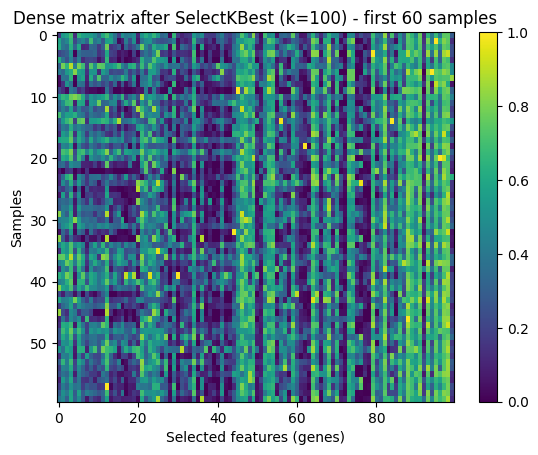

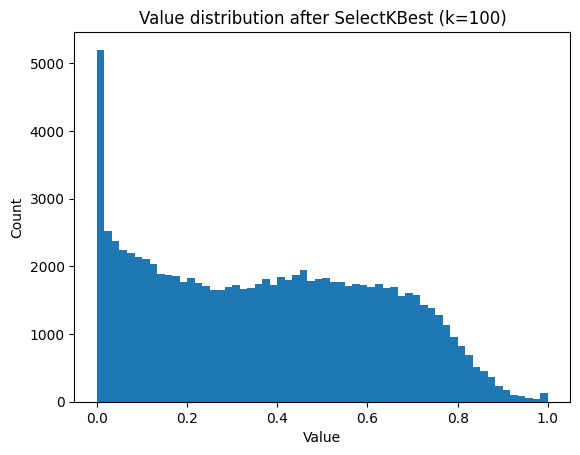

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.util import Surv

# ======================
# 1) Load + make y
# ======================
MATRIX_PATH   = "/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/brca_matrix_with_label_subtyping.tsv"
CLINICAL_PATH = "/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/clinical_features_cleaned.csv"

TIME_COL  = "OS_time_days"
EVENT_COL = "OS_event"

df, gene_cols = load_and_join(
    matrix_path=MATRIX_PATH,
    clinical_path=CLINICAL_PATH,
    time_col=TIME_COL,
    event_col=EVENT_COL,
)

y = Surv.from_arrays(
    event=df[EVENT_COL].astype(bool).to_numpy(),
    time=df[TIME_COL].astype(float).to_numpy(),
)

# ======================
# 2) Gene preprocess với k=100
# ======================
k = 100
gene_pre = make_gene_preprocess(
    var_threshold=0.0,
    k0_topvar=10000,
    k_genes=k
)

Xk = gene_pre.fit_transform(df[gene_cols], y)

# đảm bảo dense float64
Xk_dense = np.asarray(Xk, dtype=np.float64, order="C")
print("Xk_dense shape:", Xk_dense.shape)  # (n_samples, 100)

# ======================
# 3) Plot: heatmap + histogram
# ======================
# Heatmap (lấy tối đa 60 sample cho dễ nhìn)
n_show = min(60, Xk_dense.shape[0])
plt.figure()
plt.imshow(Xk_dense[:n_show, :], aspect="auto")
plt.title(f"Dense matrix after SelectKBest (k={k}) - first {n_show} samples")
plt.xlabel("Selected features (genes)")
plt.ylabel("Samples")
plt.colorbar()
plt.show()

# Histogram phân bố giá trị (toàn bộ ma trận)
plt.figure()
plt.hist(Xk_dense.ravel(), bins=60)
plt.title(f"Value distribution after SelectKBest (k={k})")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


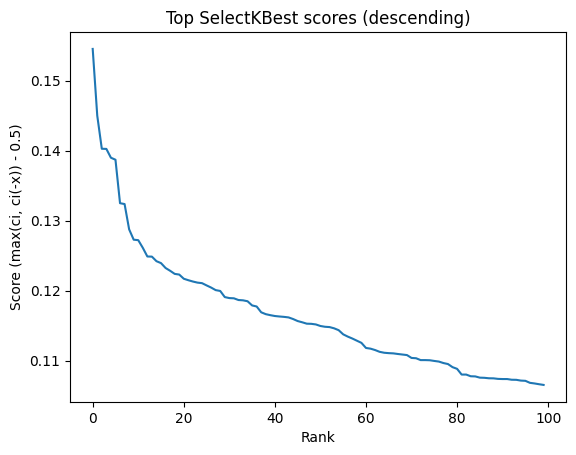

In [7]:
kbest = gene_pre.named_steps["kbest"]
scores = kbest.scores_  # score cho các feature sau các bước trước đó
top_idx = np.argsort(scores)[::-1][:k]

plt.figure()
plt.plot(scores[top_idx])
plt.title("Top SelectKBest scores (descending)")
plt.xlabel("Rank")
plt.ylabel("Score (max(ci, ci(-x)) - 0.5)")
plt.show()


In [ ]:
import pandas as pd

df= pd.read_csv("/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/clinical_features_cleaned.csv")


,submitter_id,OS_time_days,OS_event,race,ER_status,PR_status,HER2_status,ajcc_pathologic_t,ajcc_pathologic_m,laterality,...,t_suffix,ajcc_pathologic_n,n_suffix,n_is_mi,n0_i_plus,n0_mol_plus,n_micrometastasis,age_at_diagnosis_years_was_missing,lymph_nodes_positive_was_missing,lymph_nodes_tested_was_missing
0,tcga-3c-aaau,4047.0,0,white,positive,positive,negative,unknown,unknown,left,...,unknown,unknown,unknown,0,0,0,0,0,0,0
1,tcga-3c-aali,4005.0,0,black or african american,positive,positive,positive,t2,m0,right,...,none,n1,a,0,0,0,0,0,0,0
2,tcga-3c-aalj,1474.0,0,black or african american,positive,positive,equivocal,t2,m0,right,...,none,n1,a,0,0,0,0,0,0,0
3,tcga-3c-aalk,1448.0,0,black or african american,positive,positive,positive,t1,m0,right,...,c,n0,none,0,1,0,1,0,0,0
4,tcga-4h-aaak,348.0,0,white,positive,positive,equivocal,t2,m0,left,...,none,n2,a,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,tcga-w8-a86g,347.0,0,white,positive,positive,negative,t2,unknown,left,...,a,n0,none,0,0,0,0,0,0,0
914,tcga-wt-ab44,883.0,0,white,positive,positive,negative,t1,unknown,left,...,c,n0,none,0,0,0,0,1,0,0
915,tcga-xx-a899,467.0,0,white,positive,positive,negative,t1,unknown,right,...,c,n2,a,0,0,0,0,0,0,0
916,tcga-xx-a89a,488.0,0,white,positive,positive,negative,t3,unknown,left,...,none,n0,none,0,0,0,0,0,0,0


In [2]:
df["OS_event"].value_counts()

OS_event
0    799
1    119
Name: count, dtype: int64